In [519]:
from binance.client import Client
# client = Client(api_key, api_secret)
import time
import dateparser
import pytz
from datetime import datetime
import json
import pandas as pd

### Define functions (hidden)

In [520]:
#!/home/ubuntu/anaconda3/bin/python
from binance.client import Client
import time
import dateparser
import pytz
from datetime import datetime
import json

def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds
    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/
    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)


def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds
    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str
    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/
    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Biannce Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str
    :return: list of OHLCV values
    """
    # create the Binance client, no need for api key
    client = Client("", "")

    # init our list
    output_data = []

    # setup the max limit
    limit = 500

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data


# symfile = pd.read_csv("/home/ubuntu/binance_data/binance_tickers.txt", header=None, sep="\t", names=['symbol'])
# syms = [i for i in set(symfile.symbol.values)]
# outfile = "/home/ubuntu/binance_data/klines_usdsymbols.txt"

# for symbol in syms:
#     klinesa = get_historical_klines(symbol, Client.KLINE_INTERVAL_1MINUTE, "5 minutes ago UTC")
#     dfout = pd.DataFrame.from_dict(klinesa)
#     dfout['symbol'] = symbol
#     dfout['time'] = str(datetime.now())
#     dfout.to_csv(outfile, mode='a', sep="\t", header=False, index=False)

## Get your data in desired intervals 

##### Symbol "BTCUSDT" is the bitcoin - USD tether pair

##### Uses string -> datetime conversions

In [582]:
def get_ohlc(symbol, start, end="1 hour ago", interval=Client.KLINE_INTERVAL_1DAY):
    start_str = start + " UTC"
    end_str = end + " UTC"
    klinesa = get_historical_klines(symbol, interval,start_str, end_str)
    start_ts = date_to_milliseconds(start_str)
    cnames = ['open_time', 'Open', 'High', 'Low', 'Close', 'volume', 'close_time', 
              'volume', 'n_trades',' taker_buybase_volume', 'taker_buyquote_volume', 'ignore']
    odf = pd.DataFrame.from_dict(klinesa)
    odf.columns = cnames
    outdf = odf.copy()[['Open','High', 'Low', 'Close']]
    outdf.index = pd.to_datetime(odf['open_time'], unit='ms')
    cols = outdf.columns
    outdf[cols] = outdf[cols].apply(pd.to_numeric, errors='coerce')
    return outdf

In [597]:
# Get OHLC Data for 1 year starting 2 years ago in 1 Day Intervals (utilize defaults)
btcusd1d = get_ohlc("BTCUSDT", "4 years ago", "1 day ago")
print(len(btcusd1d))

# Get OHLC Data starting 6 months ago in 1 Hour Intervals
btcusd1h = get_ohlc("BTCUSDT", "6 months ago", "1 day ago", interval=Client.KLINE_INTERVAL_1HOUR)
print(len(btcusd1h))

# Get OHLC Data starting 10 days ago in 5 Minute Intervals
btcusd5min = get_ohlc("BTCUSDT", "10 days ago", "1 day ago", interval=Client.KLINE_INTERVAL_5MINUTE)
print(len(btcusd5min))


983
4355
2562


## Simple Moving Average Cross Strategy

https://kernc.github.io/backtesting.py/doc/examples/Strategies%20Library.html

In [545]:
from backtesting.test import SMA

import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy


class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 20
    atr = 1
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize all the classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Taking a first difference (`.diff()`) of a boolean
        # series results in +1, 0, and -1 values. In our signal,
        # as expected by SignalStrategy, +1 means buy,
        # -1 means sell, and 0 means to hold whatever current
        # position and wait. See the docs.
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        
        # Set the signal vector using the method provided
        # by SignalStrategy
        self.set_signal(signal)
        
        # Set trailing stop-loss to 4x ATR
        # using the method provided by TrailingStrategy
        self.set_trailing_sl(self.atr)

### Optimize n1, n2 and atr parameters

In [546]:
%%time
bt = Backtest(btcusd1h, SmaCross, commission=0.02)
stats = bt.optimize(n1=range(10, 100, 5),
                    n2=range(20, 100, 5),
                    atr=range(1, 10, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.n1 < p.n2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Searching best of 1368 configurations.
  


CPU times: user 2.82 s, sys: 2.7 s, total: 5.52 s
Wall time: 57.2 s


In [547]:
stats

Start                             2019-10-26 20:00:00
End                               2020-04-25 19:00:00
Duration                            181 days 23:00:00
Exposure [%]                                  79.6657
Equity Final [$]                              8514.53
Equity Peak [$]                               11156.8
Return [%]                                   -14.8547
Buy & Hold Return [%]                         17.1912
Max. Drawdown [%]                            -41.5232
Avg. Drawdown [%]                              -11.59
Max. Drawdown Duration              148 days 04:00:00
Avg. Drawdown Duration               29 days 05:00:00
# Trades                                           50
Win Rate [%]                                       28
Best Trade [%]                                26.3174
Worst Trade [%]                              -8.82432
Avg. Trade [%]                              -0.203012
Max. Trade Duration                  12 days 21:00:00
Avg. Trade Duration         

## Simple Moving Average 4 parameter Cross Strategy

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap.html

In [439]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 100
    n_exit = 200
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

### Optimize n1, n2, n_enter and n_exit parameters

In [497]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(btcusd5min, Sma4Cross, commission=.09)

stats, heatmap = backtest.optimize(
    n1=range(300, 7000, 1000),
    n2=range(5000, 10000, 1000),
    n_enter=range(100, 5000, 100),
    n_exit=range(10, 2500, 100),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Searching best of 14395 configurations.
  


CPU times: user 4.94 s, sys: 3.03 s, total: 7.97 s
Wall time: 4min 12s


<!-- # stats -->

In [498]:
stats

Start                                                   2020-04-16 09:05:00
End                                                     2020-04-25 09:00:00
Duration                                                    8 days 23:55:00
Exposure [%]                                                        13.0838
Equity Final [$]                                                    9495.86
Equity Peak [$]                                                       10000
Return [%]                                                         -5.04144
Buy & Hold Return [%]                                               6.85174
Max. Drawdown [%]                                                  -8.28229
Avg. Drawdown [%]                                                  -8.28229
Max. Drawdown Duration                                      4 days 22:45:00
Avg. Drawdown Duration                                      4 days 22:45:00
# Trades                                                                  1
Win Rate [%]

## Test Simple Moving Average + Relative Strength Index in Multiple Time Windows

https://kernc.github.io/backtesting.py/doc/examples/Multiple%20Time%20Frames.html

In [550]:
def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()


def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)


from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):
            
            # Buy at market price on next open, but do
            # set 8% fixed stop loss.
            self.buy(sl=.92 * price)
        
        # If the price closes 2% or more below 10-day MA
        # close the position, if any.
        elif price < .98 * self.ma10[-1]:
            self.position.close()

#### Get Google OHLC data

In [552]:
from backtesting.test import GOOG

In [554]:
%%time

backtest.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10))

CPU times: user 329 ms, sys: 486 ms, total: 816 ms
Wall time: 4.34 s


Start                                    2004-08-19 00:00:00
End                                      2013-03-01 00:00:00
Duration                                  3116 days 00:00:00
Exposure [%]                                         20.5071
Equity Final [$]                                     23090.8
Equity Peak [$]                                      23686.3
Return [%]                                           130.908
Buy & Hold Return [%]                                703.458
Max. Drawdown [%]                                   -19.2731
Avg. Drawdown [%]                                   -3.84673
Max. Drawdown Duration                     778 days 00:00:00
Avg. Drawdown Duration                      97 days 00:00:00
# Trades                                                  22
Win Rate [%]                                         63.6364
Best Trade [%]                                       25.0905
Worst Trade [%]                                     -6.21969
Avg. Trade [%]          

In [548]:
# backtest.plot()

## Look at parameter correllations with heatmaps

In [500]:
from backtesting.lib import plot_heatmaps
plot_heatmaps(heatmap, agg='mean')

Column(id='22410', ...)

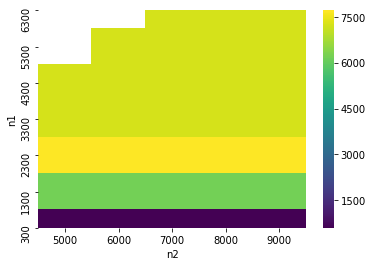

In [585]:
import seaborn as sns
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
sns.heatmap(hm[::-1], cmap='viridis')

In [595]:
btcusd1d.tail()

,Open,High,Low,Close
open_time,,,,
2020-04-21,6828.98,6940.00,6762.00,6841.37
2020-04-22,6841.36,7156.38,6818.00,7125.14
2020-04-23,7125.12,7738.00,7020.00,7482.39
2020-04-24,7483.96,7615.96,7388.00,7505.00
2020-04-25,7505.00,7705.00,7431.07,7538.67
